# Reading Data

In [22]:
# Import libraries
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

from sklearn.linear_model import LogisticRegression
from sklearn. metrics import roc_auc_score, confusion_matrix

In [2]:
import os
os.chdir("/home/rk9cx/Kaggle/")
flights_df = pd.read_csv("flights.csv", index_col=False)
flights_df.head(10)

,Unnamed: 0,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY
0,4385713,10,1,4,AA,1230,N3DBAA,ABE,ABE,5,237,1660,-19
1,4385714,10,1,4,DL,1805,N696DL,ABE,ABE,5,213,1589,-10
2,4385715,10,1,4,NK,612,N602NK,ABE,ABE,5,177,1299,-14
3,4385716,10,1,4,AA,260,N3GNAA,ABE,ABE,10,296,2342,7
4,4385717,10,1,4,AA,1982,N914UY,ABE,ABE,10,291,2296,-11
5,4385718,10,1,4,UA,684,N495UA,ABE,ABE,14,261,1846,-33
6,4385719,10,1,4,UA,1171,N68452,ABE,ABE,14,253,1744,-13
7,4385720,10,1,4,AA,448,N179UW,ABE,ABE,15,232,1727,-5
8,4385721,10,1,4,AA,2406,N859AA,ABE,ABE,15,176,1235,-1
9,4385722,10,1,4,DL,1617,N809DN,ABE,ABE,20,210,1535,-7


# Preprocessing

In [3]:
#converting response variable to 
delay_cutoff = 15
flights_df["ARRIVAL_DELAY"] = flights_df["ARRIVAL_DELAY"].apply(lambda x: 0 if x<15 else 1)
flights_df = flights_df.reset_index(drop=True)
labels_shuffle = flights_df["ARRIVAL_DELAY"]
labels_shuffle.shape

(5713508,)

In [4]:
#Function for one hot-encoding
def make_onehot_feat_dict(df, feat_key, feat_name):
    # Create features for each day of the week
    feat_vals = df[feat_key].values
    all_vals = np.unique(feat_vals)
    N_vals = len(all_vals)
    N_feat = N_vals - 1

    # Create keys
    keys = [0]*N_feat
    for i in range(N_feat):
        keys[i] = 'f_'+feat_name+'_'+ str(all_vals[i])

    # Create value for each training example in dict
    feat_dict = {}
    for i, k in enumerate(keys):
        this_day = all_vals[i]
        feat_dict[k] = feat_vals == this_day
    return feat_dict

In [5]:
#converting day of week into one-hot
daysfeat_dict = make_onehot_feat_dict(flights_df, 'DAY_OF_WEEK', 'day')

In [6]:
#converting months into one-hot
monthsfeat_dict = make_onehot_feat_dict(flights_df, 'MONTH', 'month')

In [7]:
#converting origin airport into one-hot
apfeat_dict = make_onehot_feat_dict(flights_df, 'ORIGIN_AIRPORT', 'aa')

In [8]:
#converting destination airport into one-hot
deafeat_dict = make_onehot_feat_dict(flights_df, 'DESTINATION_AIRPORT', 'da')

In [9]:
#converting Airlines into one-hot
alfeat_dict = make_onehot_feat_dict(flights_df, 'AIRLINE', 'al')

In [10]:
# Add departure hour as a feature
flights_df['HOUR_DEPARTURE'] = np.floor(flights_df['SCHEDULED_DEPARTURE'].values/100).astype(int)

In [11]:
#converting hours departure into one-hot
hrfeat_dict = make_onehot_feat_dict(flights_df, 'HOUR_DEPARTURE', 'hr')

In [12]:
all_dicts = [ daysfeat_dict, monthsfeat_dict, alfeat_dict, hrfeat_dict, apfeat_dict]
feat_dict = all_dicts[0].copy()
for d in all_dicts[1:]:
    feat_dict.update(d)

In [13]:
df_feat = pd.DataFrame.from_dict(feat_dict)
df_feat = pd.concat([df_feat, flights_df["SCHEDULED_TIME"], flights_df["DISTANCE"]], axis=1)
df_feat.shape

(5713508, 376)

# Splitting Data into Train and Test

In [14]:
airport_keys = np.array(list(apfeat_dict.keys()))
X_train = {}
X_test = {}
y_train = {}
y_test = {}
for apk in airport_keys:
    # Isolate X and y for each airport
    ap_idx = np.transpose(np.argwhere(apfeat_dict[apk]))[0]
    X_all = df_feat.loc[ap_idx].values
    y_all = labels_shuffle[ap_idx]
    
    # Calculate train and test set size
    N_flights = len(y_all)
    N_train = int(N_flights*.7)
    N_test = N_flights - N_train
    
    # Make train and test sets
    X_train[apk[-3:]] = X_all[:N_train]
    X_test[apk[-3:]] = X_all[N_train:]
    y_train[apk[-3:]] = y_all[:N_train]
    y_test[apk[-3:]] = y_all[N_train:]

# Model 1 - Logistic Regression

In [49]:
%%time
train_aucs = {}
test_aucs = {}
train_ps = {}
test_ps = {}
C = 100000
for k in X_train.keys():
    print(k)
    models = LogisticRegression(C=1)
    models.fit(X_train[k], y_train[k])
    
    # Get probabilities
    train_ps[k] = models.predict_proba(X_train[k])[:,1]
    test_ps[k] = models.predict_proba(X_test[k])[:,1]

    # Evaluate model
    train_aucs[k] = roc_auc_score(y_train[k], train_ps[k])
    test_aucs[k] = roc_auc_score(y_test[k], test_ps[k])

ABE
ABI
ABQ
ABR
ABY
ACK
ACT
ACV
ACY
ADK
ADQ
AEX
AGS
AKN
ALB
ALO
AMA
ANC
APN
ASE
ATL
ATW
AUS
AVL
AVP
AZO
BDL
BET
BFL
BGM
BGR
BHM
BIL
BIS
BJI
BLI
BMI
BNA
BOI
BOS
BPT
BQK
BQN
BRD
BRO
BRW
BTM
BTR
BTV
BUF
BUR
BWI
BZN
CAE
CAK
CDC
CDV
CEC
CHA
CHO
CHS
CID
CIU
CLD
CLE
CLL
CLT
CMH
CMI
CMX
CNY
COD
COS
COU
CPR
CRP
CRW
CSG
CVG
CWA
DAB
DAL
DAY
DBQ
DCA
DEN
DFW
DHN
DIK
DLG
DLH
DRO
DSM
DTW
DVL
EAU
ECP
EGE
EKO
ELM
ELP
ERI
ESC
EUG
EVV
EWN
EWR
EYW
FAI
FAR
FAT
FAY
FCA
FLG
FLL
FNT
FSD
FSM
FWA
GCC
GCK
GEG
GFK
GGG
GJT
GNV
GPT
GRB
GRI
GRK
GRR
GSO
GSP
GST
GTF
GTR
GUC
GUM
HDN
HIB
HLN
HNL
HOB
HOU
HPN
HRL
HSV
HYA
HYS
IAD
IAG
IAH
ICT
IDA
ILG
ILM
IMT
IND
INL
ISN
ISP
ITH
ITO
JAC
JAN
JAX
JFK
JLN
JMS
JNU
KOA
KTN
LAN
LAR
LAS
LAW
LAX
LBB
LBE
LCH
LEX
LFT
LGA
LGB
LIH
LIT
LNK
LRD
LSE
LWS
MAF
MBS
MCI
MCO
MDT
MDW
MEI
MEM
MFE
MFR
MGM
MHK
MHT
MIA
MKE
MKG
MLB
MLI
MLU
MMH
MOB
MOT
MQT
MRY
MSN
MSO
MSP
MSY
MTJ
MVY
MYR
OAJ
OAK
OGG
OKC
OMA
OME
ONT
ORD
ORF
ORH
OTH
OTZ
PAH
PBG
PBI
PDX
PHF
PHL
PHX
PIA
PIB
PIH
PIT
PLN
PNS
PPG
PSC
PSE
PSG


AUC, validation set: 0.6231159134174669
AUC, training set: 0.6812282151470526
0.6231159134174669


(0, 1)

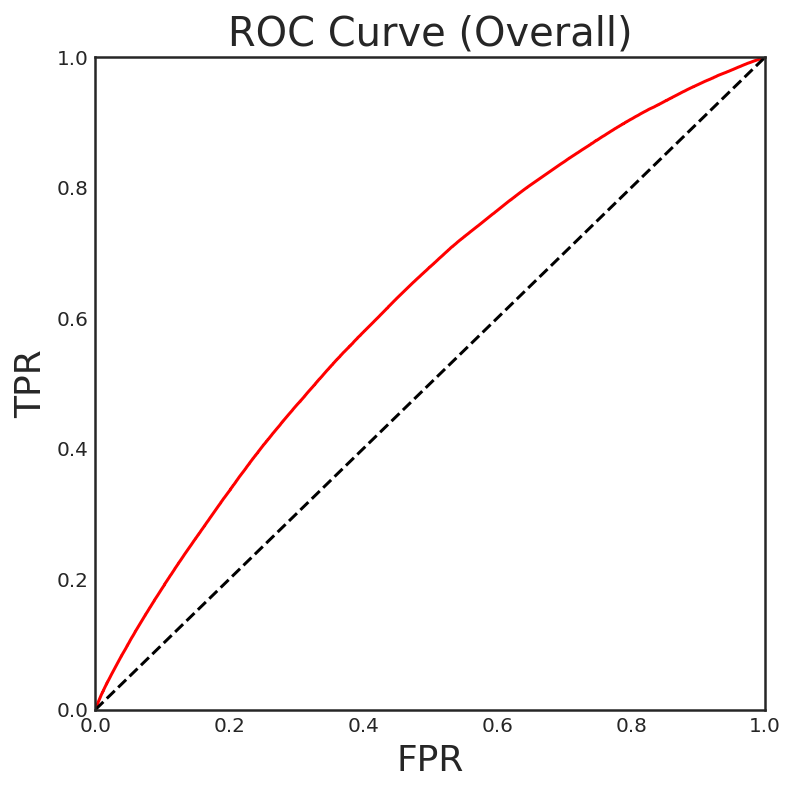

In [50]:
#AUC Calculations
all_ps = np.hstack(list(test_ps.values()))
all_ys = np.hstack(list(y_test.values()))
print('AUC, validation set:', roc_auc_score(all_ys, all_ps))

all_ps_train = np.hstack(list(train_ps.values()))
all_ys_train = np.hstack(list(y_train.values()))
print('AUC, training set:', roc_auc_score(all_ys_train, all_ps_train))


from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_ps)
print(roc_auc_score(all_ys, all_ps))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve (Overall)', fontsize=20)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xlim((0,1))
plt.ylim((0,1))

Text(0.5,1,'Prediction accuracy across airports')

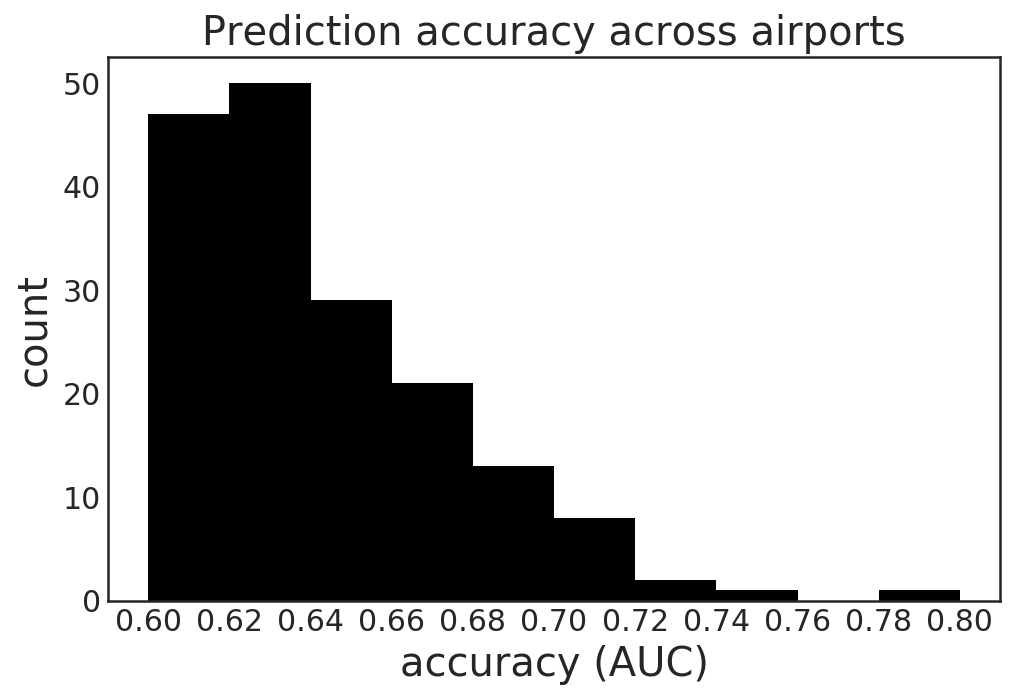

In [17]:
# Plot accuracy
plt.figure(figsize=(8,5))
accs = plt.hist(list(test_aucs.values()),bins=np.arange(0.6,0.8,0.02),color='k')
plt.xlabel('accuracy (AUC)',size=20)
plt.ylabel('count',size=20)
plt.xticks(np.arange(0.6,0.8,0.02), size=15)
plt.yticks(size=15)
plt.title('Prediction accuracy across airports',size=20)

In [33]:
decision_thresh = .5
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)

print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1425132    3819]
 [ 282435    2205]]
Precision:  0.3660358565737052
Recall:  0.007746627318718381
Accuracy:  0.8329508033130426


In [35]:
decision_thresh = .3
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)

print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1233583  195368]
 [ 215390   69250]]
Precision:  0.2616979948453998
Recall:  0.24328976953344575
Accuracy:  0.7602940258206304


In [20]:
decision_thresh = .7
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1428812     139]
 [ 284596      44]]
Precision:  0.24043715846994534
Recall:  0.0001545812254075323
Accuracy:  0.8338372458772251


# Model 2 - Random Forest

In [37]:
%%time
from sklearn.ensemble import RandomForestClassifier
train_aucs = {}
test_aucs = {}
train_ps = {}
test_ps = {}
for k in X_train.keys():
    print(k)
    models = RandomForestClassifier(n_estimators=5, random_state=0)  
    models.fit(X_train[k], y_train[k])
    
    # Get probabilities
    train_ps[k] = models.predict_proba(X_train[k])[:,1]
    test_ps[k] = models.predict_proba(X_test[k])[:,1]

    # Evaluate model
    train_aucs[k] = roc_auc_score(y_train[k], train_ps[k])
    test_aucs[k] = roc_auc_score(y_test[k], test_ps[k])

ABE
ABI
ABQ
ABR
ABY
ACK
ACT
ACV
ACY
ADK
ADQ
AEX
AGS
AKN
ALB
ALO
AMA
ANC
APN
ASE
ATL
ATW
AUS
AVL
AVP
AZO
BDL
BET
BFL
BGM
BGR
BHM
BIL
BIS
BJI
BLI
BMI
BNA
BOI
BOS
BPT
BQK
BQN
BRD
BRO
BRW
BTM
BTR
BTV
BUF
BUR
BWI
BZN
CAE
CAK
CDC
CDV
CEC
CHA
CHO
CHS
CID
CIU
CLD
CLE
CLL
CLT
CMH
CMI
CMX
CNY
COD
COS
COU
CPR
CRP
CRW
CSG
CVG
CWA
DAB
DAL
DAY
DBQ
DCA
DEN
DFW
DHN
DIK
DLG
DLH
DRO
DSM
DTW
DVL
EAU
ECP
EGE
EKO
ELM
ELP
ERI
ESC
EUG
EVV
EWN
EWR
EYW
FAI
FAR
FAT
FAY
FCA
FLG
FLL
FNT
FSD
FSM
FWA
GCC
GCK
GEG
GFK
GGG
GJT
GNV
GPT
GRB
GRI
GRK
GRR
GSO
GSP
GST
GTF
GTR
GUC
GUM
HDN
HIB
HLN
HNL
HOB
HOU
HPN
HRL
HSV
HYA
HYS
IAD
IAG
IAH
ICT
IDA
ILG
ILM
IMT
IND
INL
ISN
ISP
ITH
ITO
JAC
JAN
JAX
JFK
JLN
JMS
JNU
KOA
KTN
LAN
LAR
LAS
LAW
LAX
LBB
LBE
LCH
LEX
LFT
LGA
LGB
LIH
LIT
LNK
LRD
LSE
LWS
MAF
MBS
MCI
MCO
MDT
MDW
MEI
MEM
MFE
MFR
MGM
MHK
MHT
MIA
MKE
MKG
MLB
MLI
MLU
MMH
MOB
MOT
MQT
MRY
MSN
MSO
MSP
MSY
MTJ
MVY
MYR
OAJ
OAK
OGG
OKC
OMA
OME
ONT
ORD
ORF
ORH
OTH
OTZ
PAH
PBG
PBI
PDX
PHF
PHL
PHX
PIA
PIB
PIH
PIT
PLN
PNS
PPG
PSC
PSE
PSG


AUC, validation set: 0.5690750811001296
AUC, training set: 0.9040326115539142
0.5690750811001296


(0, 1)

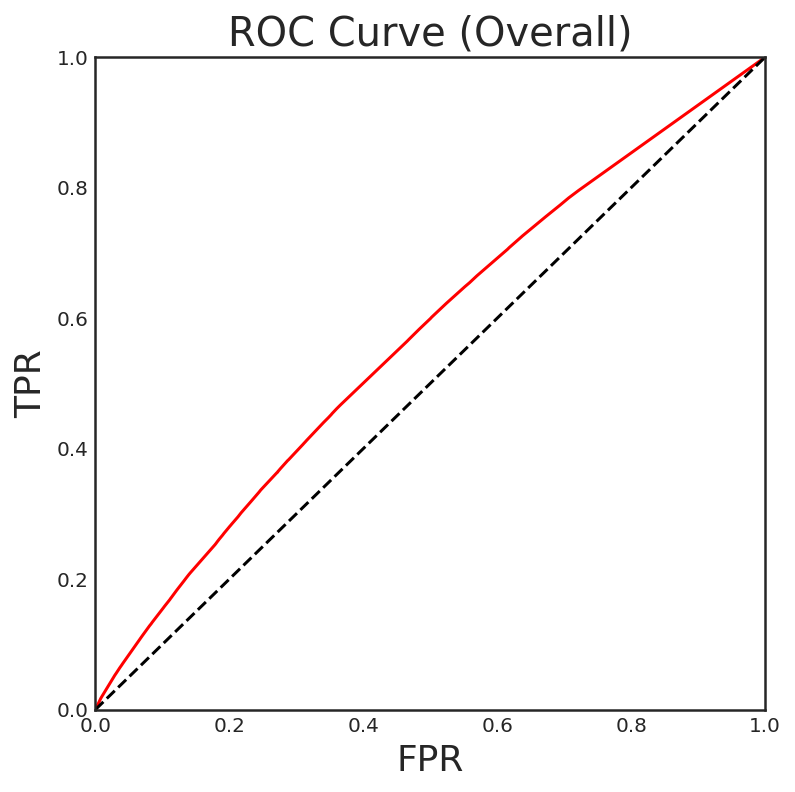

In [48]:
#AUC Calculations
all_ps = np.hstack(list(test_ps.values()))
all_ys = np.hstack(list(y_test.values()))
print('AUC, validation set:', roc_auc_score(all_ys, all_ps))

all_ps_train = np.hstack(list(train_ps.values()))
all_ys_train = np.hstack(list(y_train.values()))
print('AUC, training set:', roc_auc_score(all_ys_train, all_ps_train))


from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_ps)
print(roc_auc_score(all_ys, all_ps))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve (Overall)', fontsize=20)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xlim((0,1))
plt.ylim((0,1))

Text(0.5,1,'Prediction accuracy across airports')

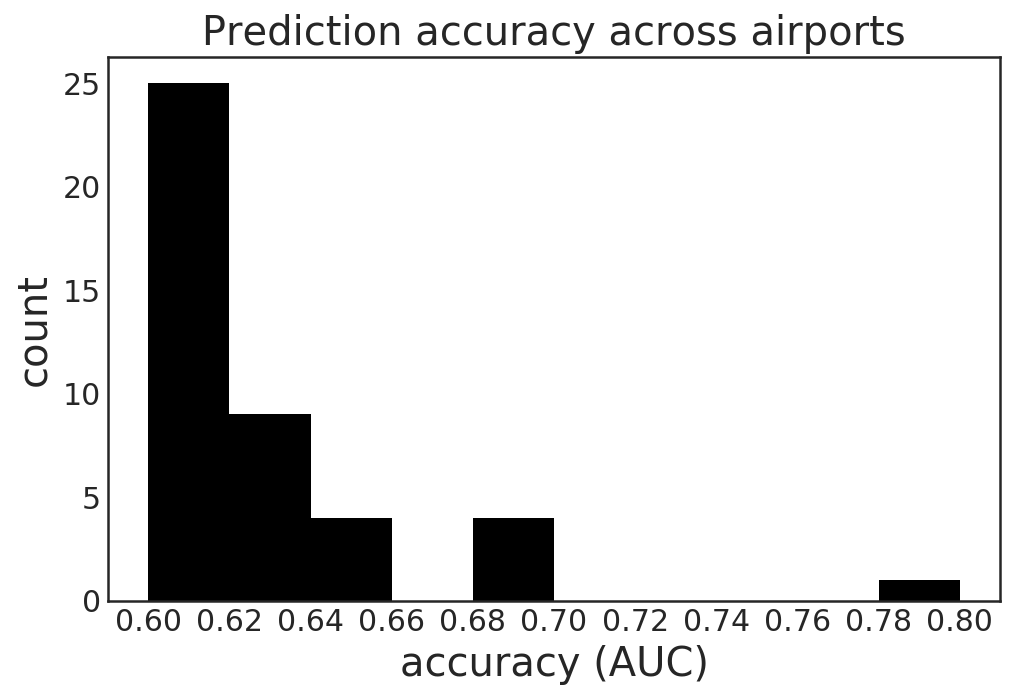

In [39]:
# Plot accuracy
plt.figure(figsize=(8,5))
accs = plt.hist(list(test_aucs.values()),bins=np.arange(0.6,0.8,0.02),color='k')
plt.xlabel('accuracy (AUC)',size=20)
plt.ylabel('count',size=20)
plt.xticks(np.arange(0.6,0.8,0.02), size=15)
plt.yticks(size=15)
plt.title('Prediction accuracy across airports',size=20)

Confusion matrix:
 [[1076164  352787]
 [ 188824   95816]]
Precision:  0.2135875150188474
Recall:  0.33662169758291177
Accuracy:  0.6839321635092621
0.544868197503903


(0, 1)

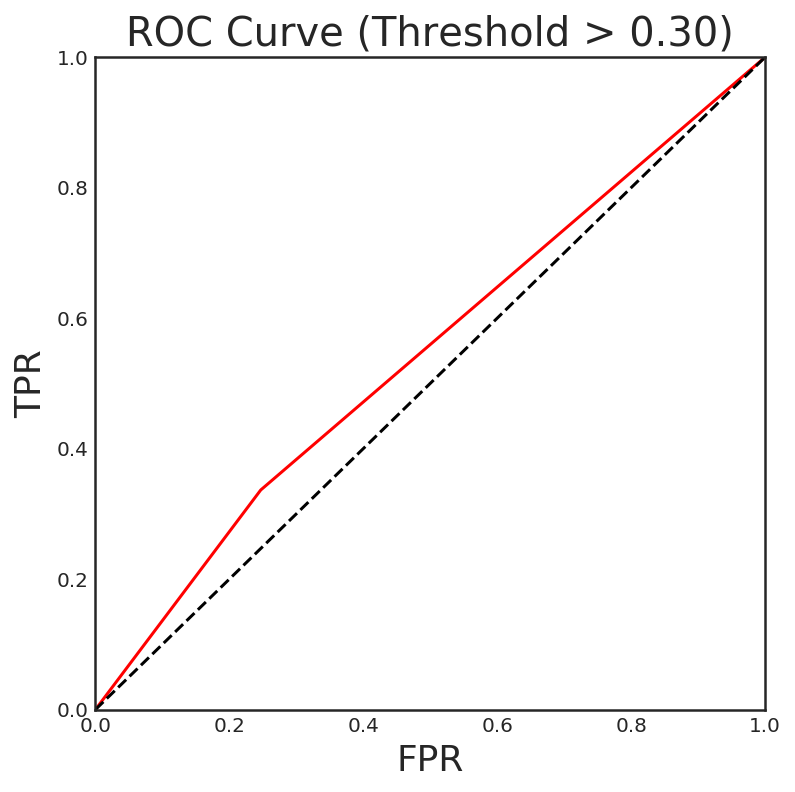

In [46]:
decision_thresh = .3
all_preds = all_ps > decision_thresh
all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve (Threshold > 0.30)', fontsize=20)
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1307689  121262]
 [ 246538   38102]]
Precision:  0.23908787430034387
Recall:  0.1338603147835863
Accuracy:  0.7853630183631917
0.524499731156044


(0, 1)

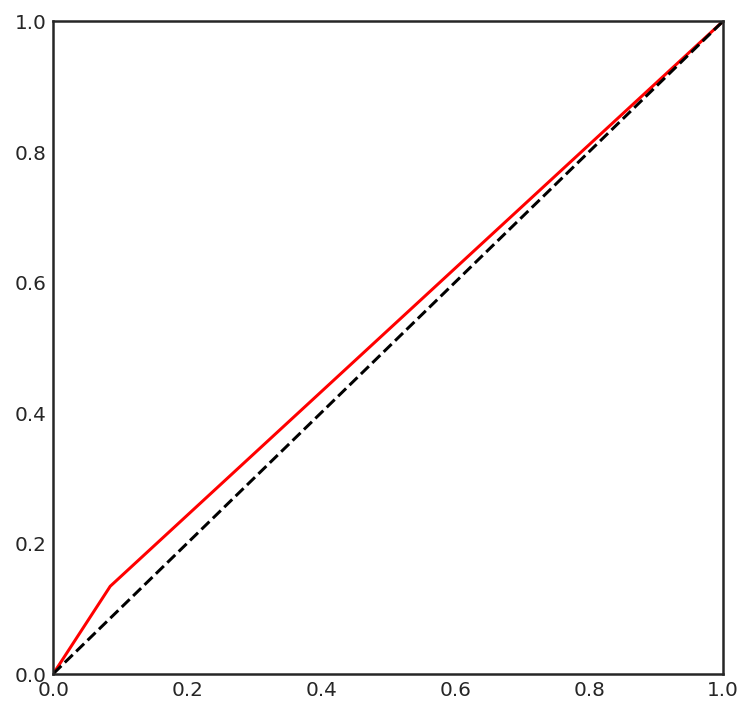

In [40]:
decision_thresh = .5
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)

print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

Confusion matrix:
 [[1393804   35147]
 [ 271651   12989]]
Precision:  0.26983962107362475
Recall:  0.045633080382237214
Accuracy:  0.8209619448281416
0.5105183578181751


(0, 1)

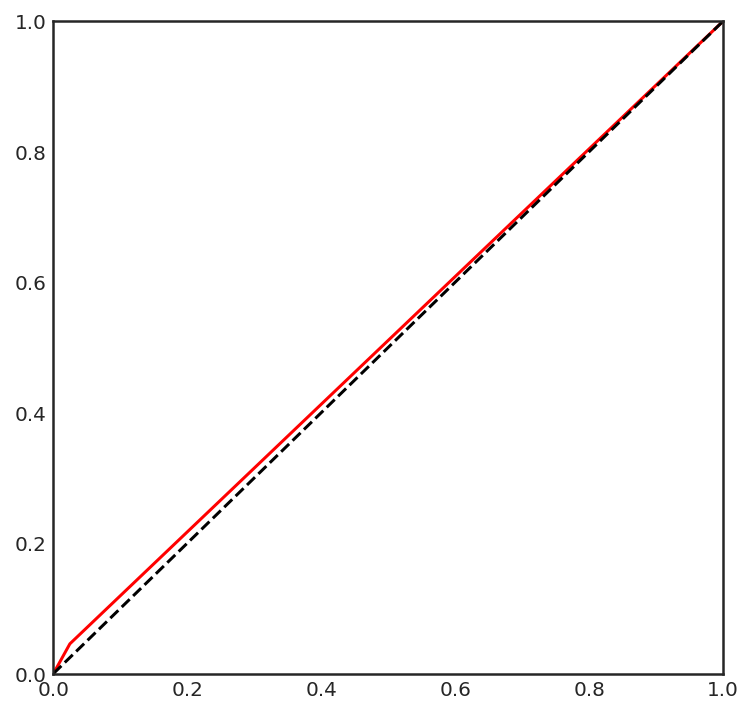

In [42]:
decision_thresh = .7
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)
print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, th = roc_curve(all_ys,all_preds)
print(roc_auc_score(all_ys, all_preds))
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,'r')
plt.plot([0,1],[0,1],'k--')
plt.xlim((0,1))
plt.ylim((0,1))

# Model 3 - Support Vector Machines

In [ ]:
%%time
from sklearn.svm import SVC
train_aucs = {}
test_aucs = {}
train_ps = {}
test_ps = {}
for k in X_train.keys():
    print(k)
    models = SVC(gamma='auto', probability=True)
    models.fit(X_train[k], y_train[k])
    
    # Get probabilities
    train_ps[k] = models.predict_proba(X_train[k])[:,1]
    test_ps[k] = models.predict_proba(X_test[k])[:,1]

    # Evaluate model
    train_aucs[k] = roc_auc_score(y_train[k], train_ps[k])
    test_aucs[k] = roc_auc_score(y_test[k], test_ps[k])

ABE
ABI
ABQ
ABR
ABY
ACK
ACT
ACV
ACY
ADK
ADQ
AEX
AGS
AKN
ALB
ALO
AMA
ANC
APN
ASE
ATL


In [ ]:
#AUC Calculations
all_ps = np.hstack(list(test_ps.values()))
all_ys = np.hstack(list(y_test.values()))
print('AUC, validation set:', roc_auc_score(all_ys, all_ps))

all_ps_train = np.hstack(list(train_ps.values()))
all_ys_train = np.hstack(list(y_train.values()))
print('AUC, training set:', roc_auc_score(all_ys_train, all_ps_train))

In [ ]:
# Plot accuracy
plt.figure(figsize=(8,5))
accs = plt.hist(list(test_aucs.values()),bins=np.arange(0.6,0.8,0.02),color='k')
plt.xlabel('accuracy (AUC)',size=20)
plt.ylabel('count',size=20)
plt.xticks(np.arange(0.6,0.8,0.02), size=15)
plt.yticks(size=15)
plt.title('Prediction accuracy across airports',size=20)

In [ ]:
decision_thresh = .5
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)

print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))

In [ ]:
decision_thresh = .3
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)

print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))

In [ ]:
decision_thresh = .7
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)

print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))

# Model 4 - Gradient Boosted Trees

In [ ]:
%%time
from sklearn.svm import SVC
train_aucs = {}
test_aucs = {}
train_ps = {}
test_ps = {}
for k in X_train.keys():
    print(k)
    models = SVC(gamma='auto', probability=True)
    models.fit(X_train[k], y_train[k])
    
    # Get probabilities
    train_ps[k] = models.predict_proba(X_train[k])[:,1]
    test_ps[k] = models.predict_proba(X_test[k])[:,1]

    # Evaluate model
    train_aucs[k] = roc_auc_score(y_train[k], train_ps[k])
    test_aucs[k] = roc_auc_score(y_test[k], test_ps[k])

In [ ]:
#AUC Calculations
all_ps = np.hstack(list(test_ps.values()))
all_ys = np.hstack(list(y_test.values()))
print('AUC, validation set:', roc_auc_score(all_ys, all_ps))

all_ps_train = np.hstack(list(train_ps.values()))
all_ys_train = np.hstack(list(y_train.values()))
print('AUC, training set:', roc_auc_score(all_ys_train, all_ps_train))

In [ ]:
# Plot accuracy
plt.figure(figsize=(8,5))
accs = plt.hist(list(test_aucs.values()),bins=np.arange(0.6,0.8,0.02),color='k')
plt.xlabel('accuracy (AUC)',size=20)
plt.ylabel('count',size=20)
plt.xticks(np.arange(0.6,0.8,0.02), size=15)
plt.yticks(size=15)
plt.title('Prediction accuracy across airports',size=20)

In [ ]:
decision_thresh = .5
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)

print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))

In [ ]:
decision_thresh = .3
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)

print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))

In [ ]:
decision_thresh = .7
all_preds = all_ps > decision_thresh


all_confuse = confusion_matrix(all_ys, all_preds)
print('Confusion matrix:\n',all_confuse)

print('Precision: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[0,1]))
print('Recall: ', all_confuse[1,1]/(all_confuse[1,1]+all_confuse[1,0]))
print('Accuracy: ', (all_confuse[0,0] + all_confuse[1,1])/(all_confuse[1,1]+all_confuse[1,0]+all_confuse[0,1] + all_confuse[0,0]))